# PDE Labs
## Edge-Averaged Finite Elements for convection-dominated elliptic problems

### Description
The main goal of this notebook is to introduce the `pyeafe` library that is publicly available and can be installed via the `pip` command.
The `pyeafe` library and simple and tightly scoped to assemble linear systems corresponding to edge-averaged finite element (EAFE) approximations
for convection-dominated elliptic problems.
Beyond this notebook, read more about `pyeafe` at [https://pypi.org/project/pyeafe/](https://pypi.org/project/pyeafe/)
and more about the EAFE method in the [original research article](https://www.ams.org/journals/mcom/1999-68-228/S0025-5718-99-01148-5/S0025-5718-99-01148-5.pdf).

### Presented analysis
This notebook presents a verification of linear convergence (in the $\mathcal{H}^1$-sense)
for an EAFE approximation of convection-dominated second order elliptic problems,
as well as a benchmark comparison demonstating that EAFE stabilizes the computed solution to a singularly perturbed problem
with a sharp boundary layer.

The problem being investigated is a standard heat equation with Dirichlet boundary conditions in two dimensions:
\begin{equation}
    -\nabla \cdot\big(\alpha \nabla u + \vec\beta u\big) + \gamma u = f, \quad\mathrm{on}\ (0, 1)\times(0, 1),
\end{equation}
where coefficients $\alpha, \vec\beta, \gamma \in \mathcal{L}_1$ and $f \in \mathcal{L}_2$.
The diffusion term is positive, $\alpha > 0$;
the convection term, $\vec\beta$, is a two-vector (matching the spatial dimension);
and the reaction term is nonnegative, $\gamma \ge 0$.
The source term, $f$, is chosen to yield a known solution so that the error of the computed solution can be compared to the interpolant of the exact solution.

Below are imports and some utility functions that simplify the presented analysis that follows.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

from typing import List
from dolfin import (
    Constant,
    DirichletBC,
    Expression,
    Function,
    FunctionSpace,
    LUSolver,
    Mesh,
    TestFunction,
    TrialFunction,
    UnitSquareMesh,
    assemble,
    dx,
    errornorm,
    grad,
    inner,
    interpolate,
)

import pyeafe

"""
    Thanks to Chris Richardson for providing the basis for the following
    plotting functions:
        https://fenicsproject.org/qa/5795/plotting-dolfin-solutions-in-matplotlib/
"""

def mesh_to_triangulation(mesh: Mesh) -> tri.Triangulation:
    if (mesh.geometry().dim() != 2):
            raise(AttributeError)

    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())


def plot_mesh(ax, mesh: Mesh):
    ax.set_aspect('equal')
    ax.set_xlabel('mesh')
    ax.triplot(mesh_to_triangulation(mesh), color='k')


def plot_solution(ax, mesh: Mesh, solution: Function, min_val=0., max_val=1.):
    ax.set_aspect('equal')
    ax.set_xlabel('computed solution')
    triang: tri.Triangulation = mesh_to_triangulation(mesh)

    if solution.vector().size() == mesh.num_cells():
        solution_array = solution.vector().array()
        return ax.tripcolor(triang, solution_array, vmin=min_val, vmax=max_val)

    else:
        solution_array = solution.compute_vertex_values(mesh)
        return ax.tripcolor(triang, solution_array, vmin=min_val, vmax=max_val, shading='gouraud')
        
        
def plot_error(ax, mesh: Mesh, exact: Function, computed: Function):
    ax.set_aspect('equal')
    ax.set_xlabel('error')
    triang: tri.Triangulation = mesh_to_triangulation(mesh)

    if exact.vector().size() == mesh.num_cells():
        exact_array = exact.vector().array()
        computed_array = computed.vector().array()
        return ax.tripcolor(triang, exact_array - computed_array, cmap='RdBu_r')

    else:
        exact_array = exact.compute_vertex_values(mesh)
        computed_array = computed.compute_vertex_values(mesh)
        return ax.tripcolor(triang, exact_array - computed_array, shading='gouraud', cmap='RdBu_r')

# The differential equation

The exact solution is defined by
\begin{equation}
    u(x_0, x_1) = \sin^2(2\pi x_0) \sin^2(2\pi x_1), \quad \mathrm{for}\ 0 \le x_0, x_1 \le 1.
\end{equation}

The corresponding diffusion term is taken to be $\alpha = 10^{-3}$,
the convection term is $\vec\beta = \begin{bmatrix} x_1 \\ -x_0 \end{bmatrix}$,
the reaction term is trivial (for simplicity), $\gamma \equiv 0$,
and source term is then given by
\begin{align}
  f(x_0, x_1)
      &= -\nabla \cdot\Big(\alpha \nabla u(x_0, x_1) + \vec\beta u(x_0, x_1)\Big) + \gamma u(x_0, x_1) \\
      &= -\alpha \Delta u(x_0, x_1) - x_1 u_{x_0}(x_0, x_1) + x_0 u_{x_1}(x_0, x_1) \\
      &= -8\times10^{-6}\pi^2 \Big(\cos(4\pi x_0) \sin^2(2\pi x_1) + \cos(4\pi x_1) \sin^2(2\pi x_0) \Big) - 2\pi \Big(x_1\sin(4\pi x_0) \sin^2(2\pi x_1) - x_0 \sin(4\pi x_1) \sin^2(2\pi x_0) \Big).
\end{align}

These functions are prescribed below using the `dolfin.Expression` class.
A polynomial degree of 4 is used so that the interpolation error does not dominate the error investigated in this analysis.
(A reaction term is set to be zero for completeness and the curious reader is encouraged to include it.)

In [2]:
exact_solution = Expression(
    "pow(sin(2. * DOLFIN_PI * x[0]) * sin(2. * DOLFIN_PI * x[1]), 2.)",
    degree=4,
)

alpha = 1e-3
gamma = 1e+0
diffusion = Constant(alpha)
convection = Expression(("x[1]", "-x[0]"), degree=1)
reaction = Constant(gamma)

source = Expression(
    """
    -8. * diffusion * DOLFIN_PI * DOLFIN_PI * ( \
        cos(4. * DOLFIN_PI * x[0]) * pow(sin(2. * DOLFIN_PI * x[1]), 2.) \
        + cos(4. * DOLFIN_PI * x[1]) * pow(sin(2. * DOLFIN_PI * x[0]), 2.) \
    ) \
    - 2. * DOLFIN_PI * ( \
        x[1] * sin(4. * DOLFIN_PI * x[0]) * pow(sin(2. * DOLFIN_PI * x[1]), 2.) \
        - x[0] * sin(4. * DOLFIN_PI * x[1]) * pow(sin(2. * DOLFIN_PI * x[0]), 2.) \
    ) \
    + reaction * pow(sin(2. * DOLFIN_PI * x[0]) * sin(2. * DOLFIN_PI * x[1]), 2.)
    """,
    diffusion=alpha,
    reaction=gamma,
    degree=4,
)

# Discretization

For EAFE, the finite element space is $C^0$ linear finite elements on the unit mesh, denoted by $\mathcal{V}_h$.
Again, `dolfin` provides the convenient `UnitSquareMesh`,
as well as `FunctionSpace`, `TrialFunction`, and `TestFunction` classes for easily defining the discretization,
as seen below.
A method is defined for returning the corresponding discretizations for a given `granularity` that determines the mesh size.

In [3]:
def discretize(granularity: int) -> (UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction):
    mesh = UnitSquareMesh(granularity, granularity)
    fe_space = FunctionSpace(mesh, "Lagrange", 1)
    trial_fn = TrialFunction(fe_space)
    test_fn = TestFunction(fe_space)
    
    return mesh, fe_space, trial_fn, test_fn

# The edge-averaged finite element (EAFE) formulation

For EAFE, the bilinear form corresponding to advection is approximated by a stable term:
\begin{equation}
    \Big(J(u_h), \nabla v_h\Big) \approx \big(\alpha \nabla u_h, \nabla v_h\big) + \big(u_h, (x_1 , -x_0) \cdot \nabla v_h\big),
\end{equation}
as described in [original article](https://www.ams.org/journals/mcom/1999-68-228/S0025-5718-99-01148-5/S0025-5718-99-01148-5.pdf) that introduces this approach.
The finite element formulation solves the following weak form of the differential equation
by finding the unique solution in the finite dimensional subspace, $\mathcal{V}_h$, of $\mathcal{H}^1$:
\begin{equation}
    \Big(J(u_h), \nabla v_h\Big) = (f, v_h), \qquad\mathrm{for\ all}\ v_h \in \mathcal{V}_h,
\end{equation}
where
$u_h(x_0, x_1) = \mathcal{I}_h\big(u(x_0, x_1)\big) = \mathcal{I}_h\big(\sin^2(2\pi x_0) \sin^2(2\pi x_1)\big)$
is the interpolated Dirichlet boundary condition.

To write the finite element formulation,
`dolfin` uses a *Unified Form Language* (UFL) compiler to easily describe the problem in a familiar form.
The compiled forms are assembled into a linear system of equations that are solved by a non-symmetric LU solver in the function below.

Since this analysis is concerned with verifying the theoretical rate of convergence for the finite element formulation,
the `compute_solution` function takes in a single parameter that describes the mesh granularity.
This makes it straightforward to compute solutions on uniformly refining meshes.

In [4]:
def compute_solution(
    granularity: int,
    diffusion_coefficient: pyeafe.Coefficient,
    convection_coefficient: pyeafe.Coefficient,
    reaction_coefficient: pyeafe.Coefficient,
    source_term: pyeafe.Coefficient,
    eafe: bool = False,
) -> Function:
    mesh, fe_space, trial_fn, test_fn = discretize(granularity)

    # assembly
    stiffness_matrix = None
    if eafe:
        stiffness_matrix = pyeafe.eafe_assemble(
            mesh,
            diffusion_coefficient,
            convection_coefficient,
            reaction_coefficient,
        )
    else:
        bilinear_form = (
            diffusion_coefficient * inner(grad(trial_fn), grad(test_fn))
            + trial_fn * inner(convection_coefficient, grad(test_fn))
            + reaction_coefficient * trial_fn * test_fn
        ) * dx
        stiffness_matrix = assemble(bilinear_form)
    
    linear_form = source_term * test_fn * dx
    rhs_vector = assemble(linear_form)

    bc = DirichletBC(fe_space, exact_solution, lambda _, bndry: bndry)
    bc.apply(stiffness_matrix, rhs_vector)

    # linear solver
    solution = Function(fe_space)
    solver = LUSolver(stiffness_matrix, "default")
    solver.parameters["symmetric"] = False
    solver.solve(solution.vector(), rhs_vector)
    
    return solution

# Convergence data

In considering the convergence of the computed EAFE solution with respect to increasing granularity of the mesh,
the following convenience class has been defined that is instantiated with a single parameter, the mesh granularity.
With this, this class computes the solution on the corresponding mesh as well as the error in the $\mathcal{H}^1$ sense.
There is also a convenient plotting method for visualizing the mesh, computed solution, and localized error.

In [5]:
class ConvergenceDatum(object):
    def __init__(self, granularity):
        self.granularity = granularity
        self.computed_solution = compute_solution(
            granularity,
            diffusion,
            convection,
            reaction,
            source,
            eafe=True,
        )

        self.error = errornorm(exact_solution, self.computed_solution, "H1", 3)
        self._mesh = self.computed_solution.function_space().mesh()
        self._interpolant = interpolate(exact_solution, self.computed_solution.function_space())

    def plot(self):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))
        axs = axs.flatten()
        plot_mesh(axs[0], self._mesh)
        plot_solution(axs[1], self._mesh, self.computed_solution)
        tcp = plot_error(axs[2], self._mesh, self._interpolant, self.computed_solution)

        fig.colorbar(tcp)
        fig.suptitle(f"At granularity {self.granularity}, the H1-error is {self.error:e}.", fontsize=14)
        plt.show()


# Numerical results
Using the convergence data class above, EAFE-approximated solutions are computed on a sequence of uniformly refined meshes with meshes, computed solutions, and errors plotted for visual inspection. 

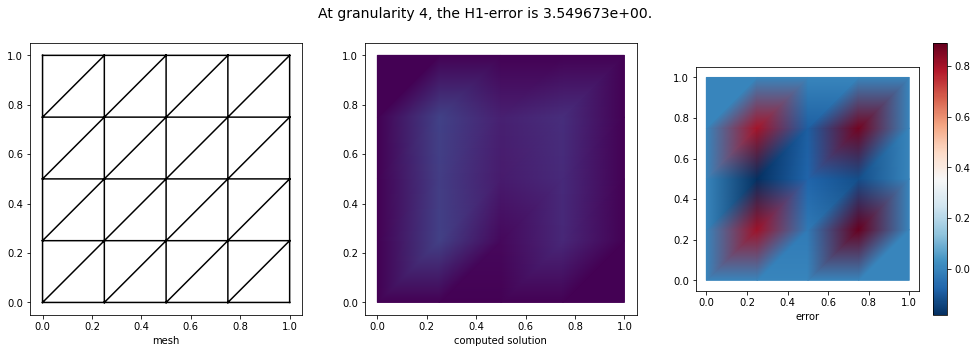

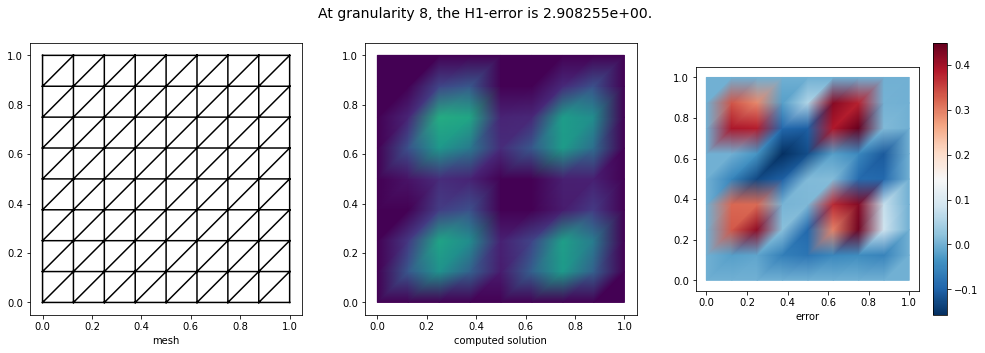

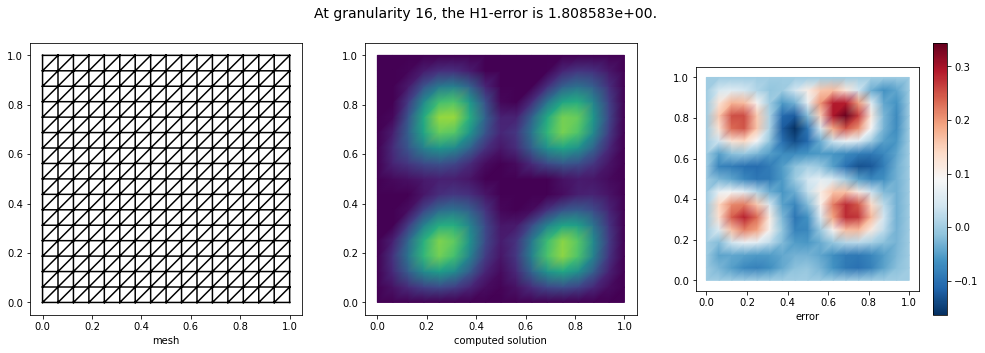

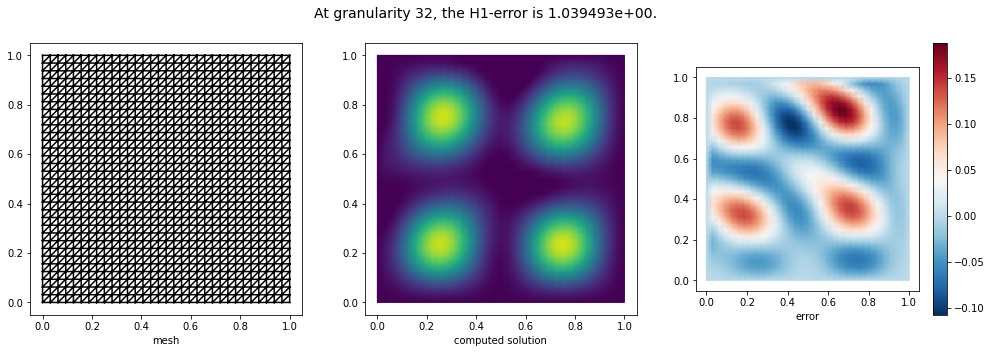

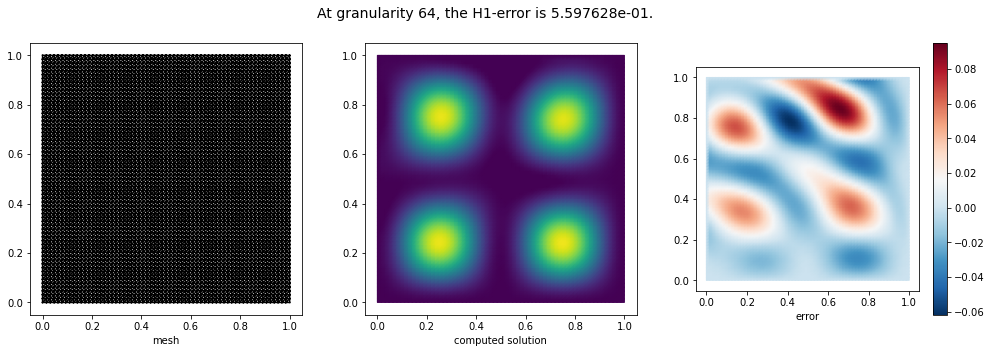

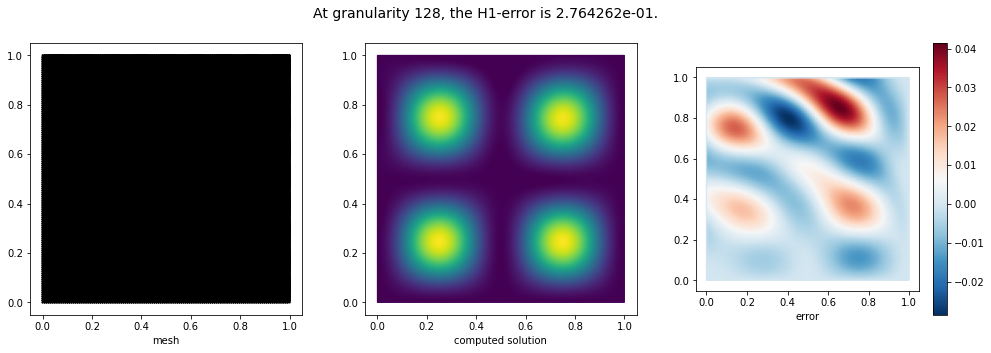

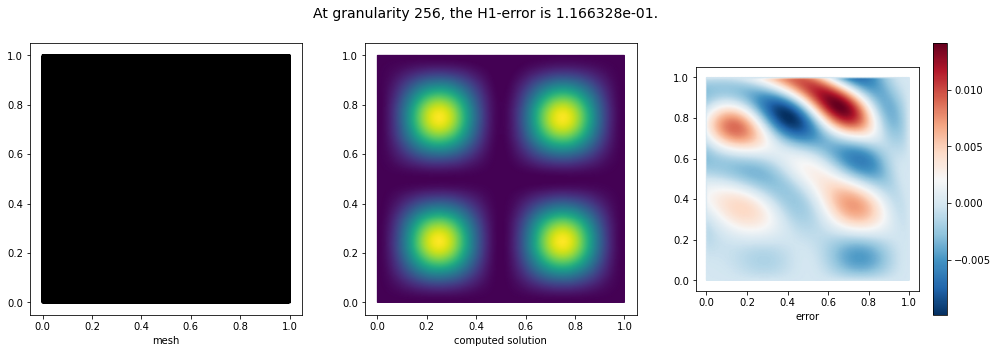

In [6]:
granularities = [4, 8, 16, 32, 64, 128, 256]
convergence_data = [ConvergenceDatum(granularity) for granularity in granularities]

for datum in convergence_data:
    datum.plot()

# Verification of convergence rate
First order (linear) finite element spaces are theoretically expected to converge in the $\mathcal{H}^1$ sense
at a rate proportional to the size of the elements in the mesh.
Mathematically, this is expressed by:
\begin{equation}
    \| u-u_h \|_1 \le C h.
\end{equation}

(For computed EAFE solutions, the error norm is proportional to an $\mathcal{H}^1$-norm that is weighted by the PDE coefficients.
These weights are incorporated into the bounding constant here for simplicity.
See [the original paper](https://www.ams.org/journals/mcom/1999-68-228/S0025-5718-99-01148-5/S0025-5718-99-01148-5.pdf) for more details.)

In [7]:
def plot_convergence_summary(data: List[ConvergenceDatum], expected_order: int = 1):
    log_g: np.array = np.log(np.array([d.granularity for d in data]))
    log_error: np.array = np.log(np.array([d.error for d in data]))
    ref_line: np.array = log_error[-1] + float(expected_order) * (log_g[-1] - log_g)

    plt.plot(log_g, ref_line, 'c--', label='$\mathcal{O}(h^' + f'{expected_order}' + ')$')
    plt.plot(log_g, log_error, 'k', label='$\log(\mathcal{H}^1-\mathrm{error})$')

    plt.title('Convergence plot')
    plt.xlabel('$\log(g)$')
    plt.legend()
    plt.show()

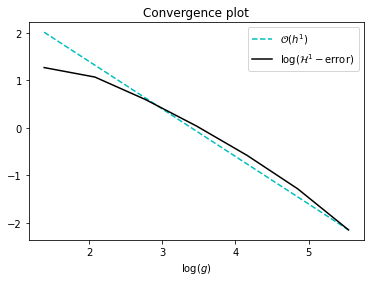

In [8]:
plot_convergence_summary(convergence_data)

# Stability comparison

The main benefits of EAFE are most apparent when considering solutions that are computed on coarse meshes rather than asymptotically.
The following benchmark is originally presented in [the original EAFE article](https://www.ams.org/journals/mcom/1999-68-228/S0025-5718-99-01148-5/S0025-5718-99-01148-5.pdf)
and shown here to validate `pyeafe` yields the expected result.

This problem is defined by:
\begin{equation}
    -\nabla \cdot \big( \alpha \nabla u + \vec\beta u \big) = 1, \quad\mathrm{on}\ (0, 1)\times(0,1),
\end{equation}
where $\alpha = 10^{-6}$, $\vec\beta = \begin{bmatrix} x_1 \\ -x_0 \end{bmatrix}$,
and $u = 0$ on the boundary.
Note that these coefficients define a severely convection-dominated problem where $\|\alpha^{-1}\vec\beta\| \propto \mathcal{O}(10^{-6})$,
yielding a steep boundary layer.

In [14]:
benchmark_diffusion = Constant(1e-6)
benchmark_convection = Expression(("x[1]", "-x[0]"), degree=1)
benchmark_reaction = Constant(0.)
benchmark_source = Constant(1.)

A utility plotting function is provided for presentation.

In [15]:
def plot_benchmark(solution: Function, title: str, max_val: float):
    mesh = solution.function_space().mesh()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
    axs = axs.flatten()

    plot_mesh(axs[0], mesh)
    tcp = plot_solution(axs[1], mesh, solution, max_val=max_val)
    fig.colorbar(tcp)
    fig.suptitle(title)

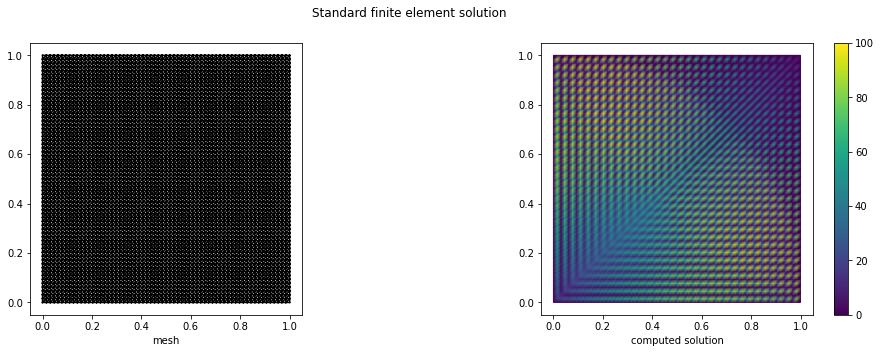

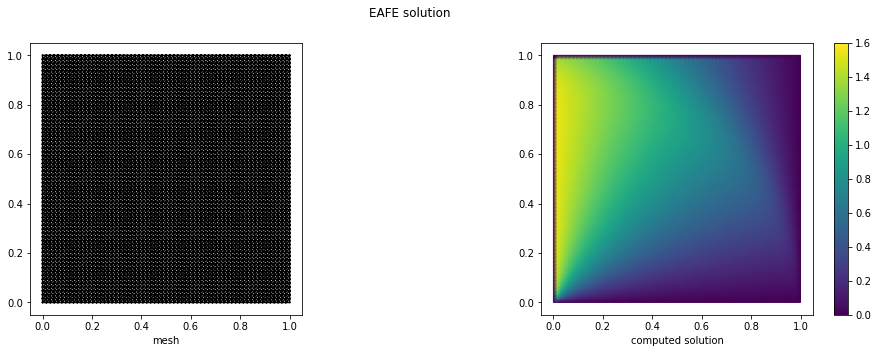

In [16]:
benchmark_solution = compute_solution(
    64,
    benchmark_diffusion,
    benchmark_convection,
    benchmark_reaction,
    benchmark_source,
    eafe=False,
)

eafe_benchmark_solution = compute_solution(
    64,
    benchmark_diffusion,
    benchmark_convection,
    benchmark_reaction,
    benchmark_source,
    eafe=True,
)

plot_benchmark(benchmark_solution, 'Standard finite element solution', 100.)
plot_benchmark(eafe_benchmark_solution, 'EAFE solution', 1.6)
plt.show()

# Summary

As seen in the above presentation, the order of convergence is verified as expected
and the EAFE approximation is able to stabilize a strongly convection-dominated problem and preserve qualitative properties like boundary layers.
Please test the `pyeafe` library, found [here]([https://pypi.org](https://pypi.org/project/pyeafe/).

Moreover, the authors hope to provide a clear example of how Jupyter notebooks,
which are ubiquitous for sharing data science and machine learning research,
can also serve the finite element and scientific computing community more generally.

Since notebooks are interactive,
it is the hope that readers modify this notebook to explore other aspects of this basic problem.

Future work includes streamlining this simple interactive environment to make it more accessible and extensible,
including examples of importing libraries for stabilizing convection-dominatied problems,
and solving nonlinear differential equations as well.